<a href="https://colab.research.google.com/github/shradhautk/AI-MICROSCOPY-WORKSHOP/blob/main/Day2_Education_Day/CNN_tutorial/DL_for_Microscopy_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL for Microscopy: U-Net 
Prepared by Tommy Wong, with sections adopted from Maxim Ziatdinov enabled by [AtomAI](https://github.com/pycroscopy/atomai).

**To run this notebook, click Runtime -> Run all, and in Change runtime type slect a GPU. Make sure to specify filenames and uncomment cells according to instructions.**

---



---


This notebook show how to apply a UNet-like neural network for semantic segmentation of TEM images



Install AtomAI:

In [ ]:
!pip install git+https://github.com/pycroscopy/atomai # install the latest version from source

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pycroscopy/atomai to /tmp/pip-req-build-j4hgpbub
  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/atomai /tmp/pip-req-build-j4hgpbub
  Resolved https://github.com/pycroscopy/atomai to commit 6d187296074143d017ca8fc60302364cd946b180
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 68.3 MB/s eta 0:00:00
  Created wheel for atomai: filename=atomai-0.7.8-py3-none-any.whl size=162558 sha256=4f1666765fb0192c64e16e591e7df8df28fe883e61c93ff2574296400400fbae
  Stored in directory: /tmp/pip-ephem-wheel-cac

Imports:

In [ ]:
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt

## Semantic segmentation

Download training/test data:

In [ ]:
# Training data
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/CNN_tutorial/DL_for_Microscopy_unet_train_imgs.npy'
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/CNN_tutorial/DL_for_Microscopy_unet_train_labs.npy'

# Data for prediction
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/CNN_tutorial/test_image.png'
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/CNN_tutorial/test_label.png'

--2023-06-06 13:45:23--  https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/CNN_tutorial/DL_for_Microscopy_unet_train_imgs.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388736 (8.0M) [application/octet-stream]
Saving to: ‘DL_for_Microscopy_unet_train_imgs.npy’

DL_for_Microscopy_u 100%[===================>]   8.00M  --.-KB/s    in 0.02s   

2023-06-06 13:45:24 (457 MB/s) - ‘DL_for_Microscopy_unet_train_imgs.npy’ saved [8388736/8388736]

--2023-06-06 13:45:24--  https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/CNN_tutorial/DL_for_Microscopy_unet_train_labs.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.11

In [ ]:
# Load train/test data (this is a simple dataset generated just from a single image)
images = np.load('DL_for_Microscopy_unet_train_imgs.npy')[:, None, ...][:-2]
labels = np.load('DL_for_Microscopy_unet_train_labs.npy')[:-2]
#Let's use the last 2 image for validation during training
images_test = np.load('DL_for_Microscopy_unet_train_imgs.npy')[:, None, ...][-2:]
labels_test = np.load('DL_for_Microscopy_unet_train_labs.npy')[-2:]
# Load data for prediction
expdata = plt.imread('test_image.png')
expdata_GT = plt.imread('test_label.png') # Ground truth

In [ ]:
print(images.shape, labels.shape)
print(images_test.shape, labels_test.shape)

(30, 1, 256, 256) (30, 256, 256)
(2, 1, 256, 256) (2, 256, 256)


The training/test images and masks represent 4 separate numpy arrays with the dimensions (n_images, n_channels=1, image_height, image_width) for training/test images, and (n_images, image_height, image_width) for the associated masks (aka ground truth). The reason that our images have 4 dimensions, while our labels have only 3 dimensions is because of how the cross-entropy loss is calculated in PyTorch (see [here](https://pytorch.org/docs/stable/nn.html#nllloss)). Briefly, if you have multiple channels corresponding to different classes in your labeled data, you'll need to map your target classes to tensor indices. Here, we already did this for our training and test data during the preparation stage and so everything is ready for training.

Let's plot some of the training data:

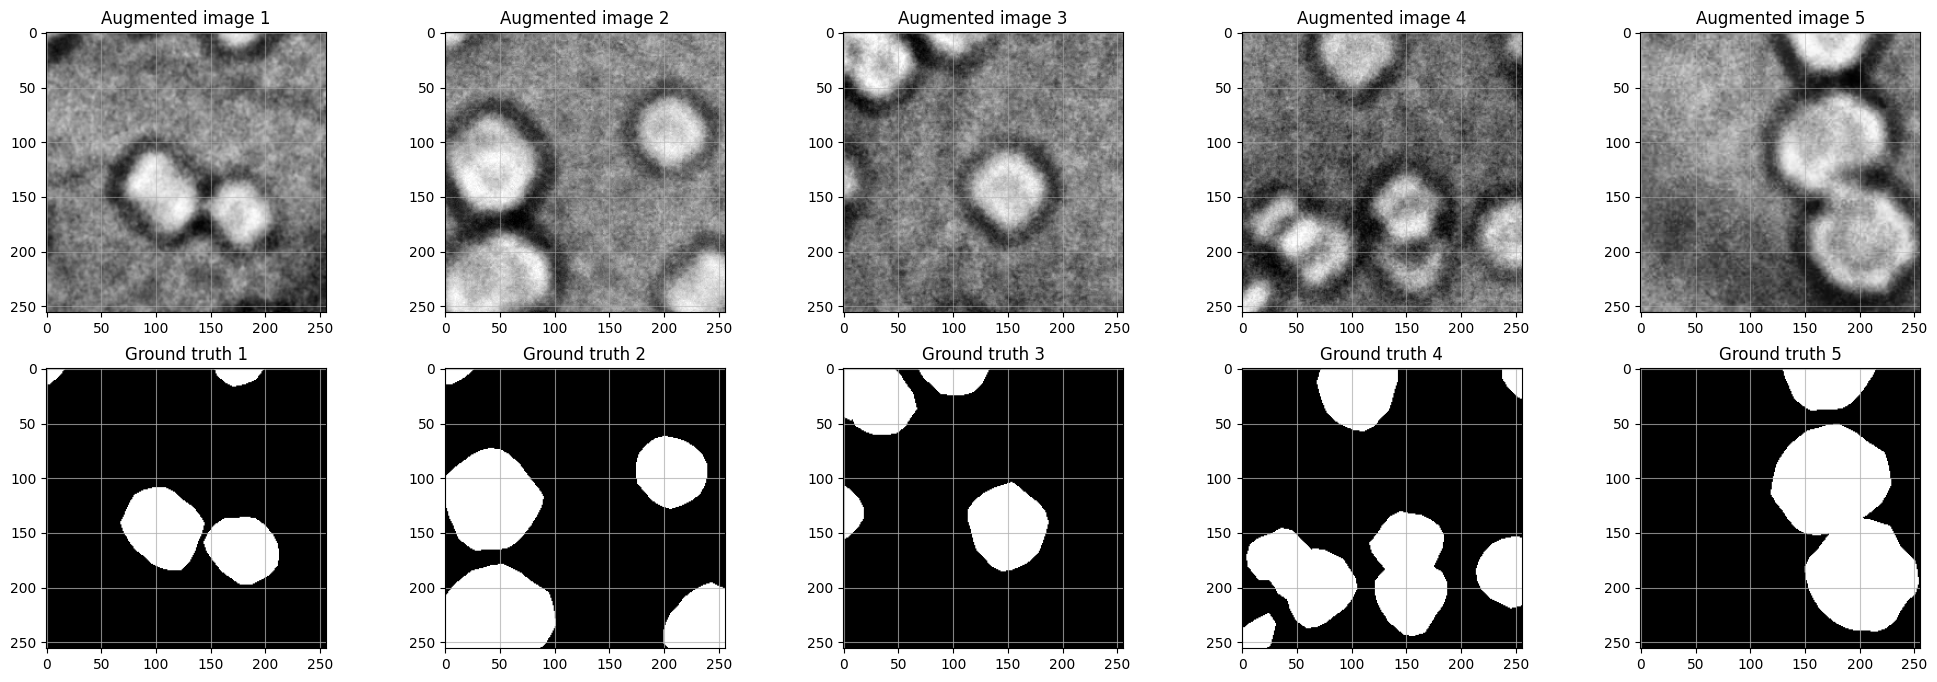

In [ ]:
n = 5 # number of images to plot

n = n + 1
fig = plt.figure( figsize=(30, 8))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i))
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(labels[i-1], cmap='gist_gray')
    ax.set_title('Ground truth ' + str(i))
    ax.grid(alpha=0.75)

The neural network will be trained to take the images in the top row (see plot above) as the input and to output clean images of circular-shaped "blobs" on a uniform background in the bottom row, from which one can identify the xy centers of atoms.

We are going to use a [UNet](https://en.wikipedia.org/wiki/U-Net)-like neural network for semantic segmentation. In the semantic segmentation tasks we aim at categorizing every pixel in the image. This is different form a regular image-level classification tasks, where we categorize the image as whole (e.g. this image has a cat/dog, etc.). Here's a nice illustration from this [free book](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf):

<img src="https://drive.google.com/uc?export=view&id=18N4x3P0whH91OcpBOOkDprgWVo-36i34" width=800 px><br><br>

Initialize a nodel for semantic segmentation:

In [ ]:
model = aoi.models.Segmentor(nb_classes=1)

We can also "print" the neural network:

In [ ]:
print(model.net)

Unet(
  (c1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c3): ConvBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

Train the initialized model:

The model dafaults to using Adam optimizer w/ learning rate=1e-3, BCE loss, and batch size of 32

(Here the accuracy is calculated as [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) (IoU) score, which is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between them)

/usr/local/lib/python3.10/dist-packages/atomai/utils/preproc.py:64: UserWarning: Adding a channel dimension of 1 to training labels
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/atomai/utils/preproc.py:69: UserWarning: Adding a channel dimension of 1 to test labels
  warnings.warn(


Epoch 1/300 ... Training loss: 0.3346 ... Test loss: 0.5291 ... Train Accuracy: 0.8957 ... Test Accuracy: 0.4177 ... GPU memory usage: 2453/40960
Epoch 100/300 ... Training loss: 0.1299 ... Test loss: 0.1434 ... Train Accuracy: 0.9437 ... Test Accuracy: 0.9221 ... GPU memory usage: 2455/40960
Epoch 200/300 ... Training loss: 0.0901 ... Test loss: 0.0754 ... Train Accuracy: 0.9329 ... Test Accuracy: 0.9224 ... GPU memory usage: 2455/40960
Epoch 300/300 ... Training loss: 0.0879 ... Test loss: 0.0619 ... Train Accuracy: 0.9219 ... Test Accuracy: 0.9244 ... GPU memory usage: 2455/40960
Model (final state) evaluation loss: 0.0619
Model (final state) accuracy: 0.9244
Performing stochastic weight averaging...
Model (final state) evaluation loss: 0.0615
Model (final state) accuracy: 0.9214
Plotting training history


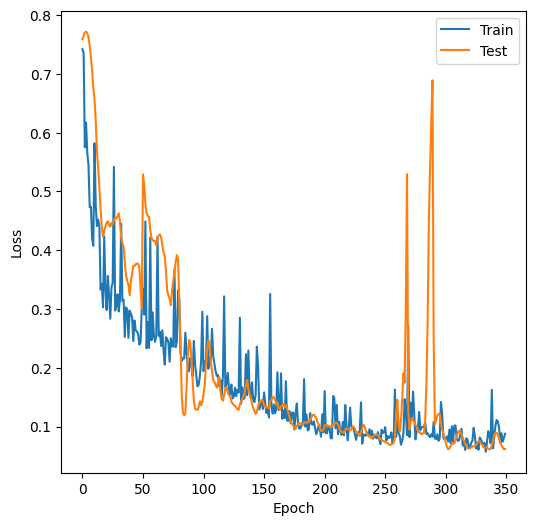

In [ ]:
model.fit(images, labels, images_test, labels_test, # training data
          training_cycles=300, compute_accuracy=True, swa=True, batch_size=2 # training parameters
) 

Now let's make a prediction on the image:

In [ ]:
nn_output = model.predict(expdata, compute_coords=False)

Batch 1/1

Plot raw prediction:

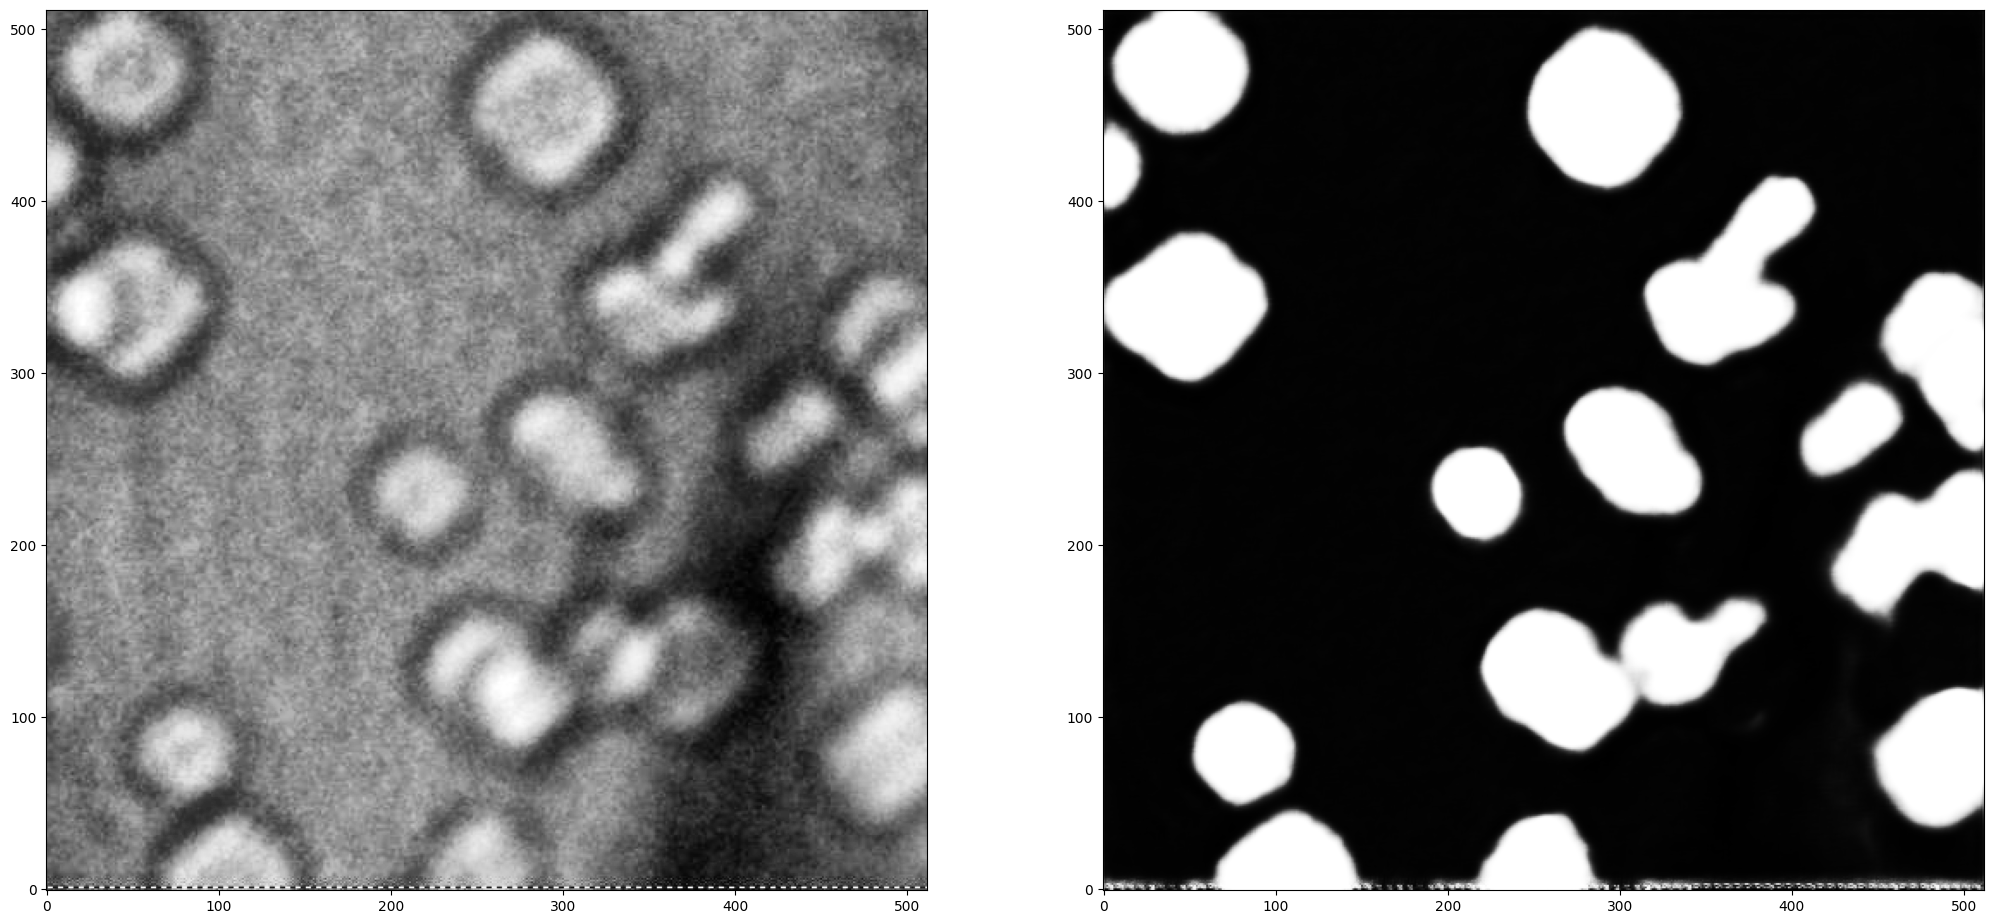

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
ax1.imshow(expdata, cmap='gray', origin="lower")
ax2.imshow(nn_output[0, ..., 0], cmap='gray', origin="lower")